# Лабораторная 3. RNN, LSTM и GRU

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
from numpy import trapz
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [2]:
# Read data
data = pd.read_csv('Steel_industry_data.csv')
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
data.set_index('date', inplace=True)

In [3]:
data

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
date,,,,,,,,,,
2018-01-01 00:15:00,3.17,2.95,0.00,0.0,73.21,100.00,900,Weekday,Monday,Light_Load
2018-01-01 00:30:00,4.00,4.46,0.00,0.0,66.77,100.00,1800,Weekday,Monday,Light_Load
2018-01-01 00:45:00,3.24,3.28,0.00,0.0,70.28,100.00,2700,Weekday,Monday,Light_Load
2018-01-01 01:00:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,Weekday,Monday,Light_Load
2018-01-01 01:15:00,3.82,4.50,0.00,0.0,64.72,100.00,4500,Weekday,Monday,Light_Load
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:00:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,Weekday,Monday,Light_Load
2018-12-31 23:15:00,3.74,3.74,0.00,0.0,70.71,100.00,83700,Weekday,Monday,Light_Load
2018-12-31 23:30:00,3.78,3.17,0.07,0.0,76.62,99.98,84600,Weekday,Monday,Light_Load


In [4]:
label_encoder = LabelEncoder()

data['WeekStatus_encoded'] = label_encoder.fit_transform(data['WeekStatus'])
data = data.drop('WeekStatus', axis=1)

data['Day_of_week_encoded'] = label_encoder.fit_transform(data['Day_of_week'])
data = data.drop('Day_of_week', axis=1)

data['Load_Type_encoded'] = label_encoder.fit_transform(data['Load_Type'])
data = data.drop('Load_Type', axis=1)

# Select feature columns for training, using only 'Usage_kWh'
features = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)','Lagging_Current_Power_Factor','Leading_Current_Power_Factor', 'NSM']


In [5]:
data

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus_encoded,Day_of_week_encoded,Load_Type_encoded
date,,,,,,,,,,
2018-01-01 00:15:00,3.17,2.95,0.00,0.0,73.21,100.00,900,0,1,0
2018-01-01 00:30:00,4.00,4.46,0.00,0.0,66.77,100.00,1800,0,1,0
2018-01-01 00:45:00,3.24,3.28,0.00,0.0,70.28,100.00,2700,0,1,0
2018-01-01 01:00:00,3.31,3.56,0.00,0.0,68.09,100.00,3600,0,1,0
2018-01-01 01:15:00,3.82,4.50,0.00,0.0,64.72,100.00,4500,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:00:00,3.85,4.86,0.00,0.0,62.10,100.00,82800,0,1,0
2018-12-31 23:15:00,3.74,3.74,0.00,0.0,70.71,100.00,83700,0,1,0
2018-12-31 23:30:00,3.78,3.17,0.07,0.0,76.62,99.98,84600,0,1,0


In [248]:
data[train_size-1: -1]

array([[0.04510752, 0.0791456 , 0.        , ..., 1.        , 0.33333333,
        0.        ],
       [0.0363914 , 0.0728511 , 0.        , ..., 1.        , 0.33333333,
        0.        ],
       [0.03022013, 0.06727892, 0.        , ..., 1.        , 0.33333333,
        0.        ],
       ...,
       [0.02379438, 0.03859251, 0.        , ..., 0.        , 0.16666667,
        0.        ],
       [0.02404886, 0.03271076, 0.00252161, ..., 0.        , 0.16666667,
        0.        ],
       [0.02404886, 0.03157569, 0.00396254, ..., 0.        , 0.16666667,
        0.        ]])

In [242]:
# Data normalization
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(data) * 0.80) + 4
train_data, test_data = data[:train_size], data[train_size:]



In [267]:
num_states = 3
X_train = []
y_train = []
# Prepare train dataset
for i in range(train_data.shape[0] - num_states - 1):
    X_train.append(train_data[i:i+num_states])
    y_train.append(train_data[i+num_states][0])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [372]:
# Prepare test dataset
X_test = []
y_test = []
for i in range(test_data.shape[0] - num_states - 1):
    X_test.append(test_data[i:i+num_states])
    y_test.append(test_data[i+num_states][0])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [83]:
def get_batches(data, batch_size):
  n = len(data)
  get_X = lambda z: z[0]
  get_y = lambda z: z[1]
  for i in range(0, n, batch_size):
    batch = data[i:i+batch_size]
    yield np.array([get_X(b) for b in batch]), np.array([get_y(b) for b in batch])

In [464]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.square(tanh(x))

def mse(y_pred, y):
    err = np.mean(np.square(y - y_pred))
    return err

def dmse(y_pred, y):
#     n = y.shape[0]
    return (y_pred - y)

def relu(x):
    return (x >= 0) * x

def relu2deriv(output):
    return output >= 0

In [283]:
seed = 884736743
rng = np.random.default_rng(seed)

In [711]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.Wxh = np.random.randn(hidden_size, input_size)
        self.Whh = np.random.randn(hidden_size, hidden_size)
        self.Why = np.random.randn(output_size, hidden_size)
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        
        self.zero_grads()
        
    def zero_grads(self):
        self.dWxh = np.zeros(self.Wxh.shape)
        self.dWhh = np.zeros(self.Whh.shape)
        self.dWhy = np.zeros(self.Why.shape)
        self.dbh = np.zeros(self.bh.shape)
        self.dby = np.zeros(self.by.shape)
        
    
    def backward(self,y_pred, y_true):
        for i in range(y_pred.shape[0]):
            loc_grad = dmse(y_pred[i],y_true[i]) 
            loc_grad = loc_grad * relu2deriv(self.ys[i]) 
            loc_grad = loc_grad.reshape((loc_grad.shape[0], 1)) 
            self.dWhy += np.dot(loc_grad, self.h.T) #
            self.dby += loc_grad
            loc_grad = np.dot(self.Why.T, loc_grad)
            for j in range(self.xs.shape[1]-1,-1,-1):
#                 loc_grad = np.dot(loc_grad, dtanh(self.hs[i,j]))
                loc_grad = loc_grad * dtanh(self.hs[i,j])
                self.dWxh += np.dot(loc_grad, self.xs[i,j].reshape((self.xs[i,j].shape[0],1)).T)
                self.dWhh += np.dot(loc_grad, self.hs_act[i,j].T)
                self.dbh += loc_grad
                loc_grad = np.dot(self.Whh.T, loc_grad)
            
            
    def update_weights(self, lr):
        self.Wxh = self.Wxh - lr*self.dWxh 
        self.Whh = self.Whh - lr*self.dWhh 
        self.Why = self.Why - lr*self.dWhy
        self.bh = self.bh - lr*self.dbh 
        self.by = self.by - lr*self.dby
        
    
    def train(self,  X_train, y_train, epochs = 100, lr = 0.0001,batch_size = 64):
        dataset = list(zip(X_train, y_train))
        losses = []
        for epoch in tqdm(range(epochs)):
            rng.shuffle(dataset)
            ep_loss = []
            for (X_batch, y_batch) in (get_batches(dataset, batch_size)):
                preds = self.forward(X_batch)
                ep_loss.append(mse(np.array(preds), y_batch))
                self.backward(np.array(preds), y_batch)
                self.update_weights(lr)
#                 print(f"Batch error is : {ep_loss[-1]}")
                self.zero_grads()
            
            losses.append(np.array(ep_loss).mean())
            print(f"Epoch №{epoch + 1}, epoch loss is {losses[-1]}")
        return losses
        
    def forward(self, X):
        predictions = []
        self.ys = []
        self.hs = []
        self.hs_act = []
        for x in X:
            hs_cur = []
            hs_act_cur = []
            self.h = np.zeros((self.hidden_size, 1))
            hs_act_cur.append(self.h)
            for x_i in x:
                x_i_r = x_i.reshape(self.input_size, 1)
                self.h = np.dot(self.Wxh, x_i_r) + np.dot(self.Whh, self.h) + self.bh
                hs_cur.append(self.h)
                self.h = np.tanh(self.h)
                hs_act_cur.append(self.h)
            
            self.hs.append(hs_cur)
            self.hs_act.append(hs_act_cur)
            y = np.dot(self.Why, self.h) + self.by
            self.ys.append(y)
            y = relu(y)
            predictions.append(y.item())
        self.ys = np.array(self.ys)
        self.hs = np.array(self.hs)
        self.hs_act = np.array(self.hs_act)
        self.xs = X
        return predictions
            

In [742]:
rnn = RNN(10,3,1)

In [743]:
rnn_losses = rnn.train(X_train, y_train, epochs = 100, lr = 0.0001,batch_size = 64)

  1%|▊                                                                                 | 1/100 [00:08<13:46,  8.35s/it]

Epoch №1, epoch loss is 0.05495108801420042


  2%|█▋                                                                                | 2/100 [00:16<13:28,  8.25s/it]

Epoch №2, epoch loss is 0.03391072712243828


  3%|██▍                                                                               | 3/100 [00:24<13:20,  8.25s/it]

Epoch №3, epoch loss is 0.03300712825016322


  4%|███▎                                                                              | 4/100 [00:33<13:37,  8.51s/it]

Epoch №4, epoch loss is 0.03235712897878441


  5%|████                                                                              | 5/100 [00:42<13:32,  8.56s/it]

Epoch №5, epoch loss is 0.031611794864262355


  6%|████▉                                                                             | 6/100 [00:50<13:10,  8.41s/it]

Epoch №6, epoch loss is 0.03098828582105805


  7%|█████▋                                                                            | 7/100 [00:58<12:42,  8.20s/it]

Epoch №7, epoch loss is 0.030309054832051954


  8%|██████▌                                                                           | 8/100 [01:05<12:17,  8.02s/it]

Epoch №8, epoch loss is 0.029588728537825525


  9%|███████▍                                                                          | 9/100 [01:13<11:58,  7.90s/it]

Epoch №9, epoch loss is 0.028985265528577057


 10%|████████                                                                         | 10/100 [01:21<12:06,  8.07s/it]

Epoch №10, epoch loss is 0.028385867985428886


 11%|████████▉                                                                        | 11/100 [01:29<11:47,  7.95s/it]

Epoch №11, epoch loss is 0.027965924462669177


 12%|█████████▋                                                                       | 12/100 [01:37<11:35,  7.91s/it]

Epoch №12, epoch loss is 0.02734983198075686


 13%|██████████▌                                                                      | 13/100 [01:46<11:54,  8.21s/it]

Epoch №13, epoch loss is 0.026950111608959368


 14%|███████████▎                                                                     | 14/100 [01:55<12:15,  8.55s/it]

Epoch №14, epoch loss is 0.02664553194208802


 15%|████████████▏                                                                    | 15/100 [02:04<12:26,  8.79s/it]

Epoch №15, epoch loss is 0.026273557394336455


 16%|████████████▉                                                                    | 16/100 [02:14<12:25,  8.88s/it]

Epoch №16, epoch loss is 0.025824627693354103


 17%|█████████████▊                                                                   | 17/100 [02:23<12:32,  9.06s/it]

Epoch №17, epoch loss is 0.02543079672606459


 18%|██████████████▌                                                                  | 18/100 [02:32<12:12,  8.93s/it]

Epoch №18, epoch loss is 0.02489975174149716


 19%|███████████████▍                                                                 | 19/100 [02:41<12:08,  8.99s/it]

Epoch №19, epoch loss is 0.024384594356836552


 20%|████████████████▏                                                                | 20/100 [02:50<12:12,  9.16s/it]

Epoch №20, epoch loss is 0.024021464866767178


 21%|█████████████████                                                                | 21/100 [02:59<11:47,  8.95s/it]

Epoch №21, epoch loss is 0.02364839827035157


 22%|█████████████████▊                                                               | 22/100 [03:09<12:00,  9.24s/it]

Epoch №22, epoch loss is 0.02323435830106321


 23%|██████████████████▋                                                              | 23/100 [03:17<11:37,  9.06s/it]

Epoch №23, epoch loss is 0.022883942485728725


 24%|███████████████████▍                                                             | 24/100 [03:25<10:59,  8.68s/it]

Epoch №24, epoch loss is 0.022453751468211335


 25%|████████████████████▎                                                            | 25/100 [03:34<10:52,  8.71s/it]

Epoch №25, epoch loss is 0.022084034284687668


 26%|█████████████████████                                                            | 26/100 [03:43<11:00,  8.93s/it]

Epoch №26, epoch loss is 0.021549873710643434


 27%|█████████████████████▊                                                           | 27/100 [03:51<10:30,  8.64s/it]

Epoch №27, epoch loss is 0.02105060811779679


 28%|██████████████████████▋                                                          | 28/100 [03:59<10:09,  8.46s/it]

Epoch №28, epoch loss is 0.020712427660143296


 29%|███████████████████████▍                                                         | 29/100 [04:09<10:24,  8.79s/it]

Epoch №29, epoch loss is 0.020349781735487852


 30%|████████████████████████▎                                                        | 30/100 [04:17<09:56,  8.52s/it]

Epoch №30, epoch loss is 0.019984702361608948


 31%|█████████████████████████                                                        | 31/100 [04:26<10:02,  8.73s/it]

Epoch №31, epoch loss is 0.019640821484955405


 32%|█████████████████████████▉                                                       | 32/100 [04:35<09:50,  8.68s/it]

Epoch №32, epoch loss is 0.019361203052636576


 33%|██████████████████████████▋                                                      | 33/100 [04:45<10:25,  9.34s/it]

Epoch №33, epoch loss is 0.018982364221355772


 34%|███████████████████████████▌                                                     | 34/100 [04:54<10:00,  9.10s/it]

Epoch №34, epoch loss is 0.018631670947933075


 35%|████████████████████████████▎                                                    | 35/100 [05:03<09:49,  9.07s/it]

Epoch №35, epoch loss is 0.018267214292611255


 36%|█████████████████████████████▏                                                   | 36/100 [05:11<09:25,  8.83s/it]

Epoch №36, epoch loss is 0.01794553209133249


 37%|█████████████████████████████▉                                                   | 37/100 [05:20<09:11,  8.76s/it]

Epoch №37, epoch loss is 0.017636417673042564


 38%|██████████████████████████████▊                                                  | 38/100 [05:27<08:42,  8.42s/it]

Epoch №38, epoch loss is 0.01733089643185522


 39%|███████████████████████████████▌                                                 | 39/100 [05:35<08:19,  8.19s/it]

Epoch №39, epoch loss is 0.01701643776914305


 40%|████████████████████████████████▍                                                | 40/100 [05:44<08:15,  8.27s/it]

Epoch №40, epoch loss is 0.016782616489411595


 41%|█████████████████████████████████▏                                               | 41/100 [05:52<08:01,  8.17s/it]

Epoch №41, epoch loss is 0.016524272530966777


 42%|██████████████████████████████████                                               | 42/100 [05:59<07:48,  8.07s/it]

Epoch №42, epoch loss is 0.016289313205067303


 43%|██████████████████████████████████▊                                              | 43/100 [06:07<07:33,  7.95s/it]

Epoch №43, epoch loss is 0.01603081941598573


 44%|███████████████████████████████████▋                                             | 44/100 [06:15<07:26,  7.97s/it]

Epoch №44, epoch loss is 0.015783252531267784


 45%|████████████████████████████████████▍                                            | 45/100 [06:23<07:17,  7.95s/it]

Epoch №45, epoch loss is 0.015570422608241754


 46%|█████████████████████████████████████▎                                           | 46/100 [06:32<07:21,  8.17s/it]

Epoch №46, epoch loss is 0.015319048113339284


 47%|██████████████████████████████████████                                           | 47/100 [06:40<07:10,  8.12s/it]

Epoch №47, epoch loss is 0.015085659892873571


 48%|██████████████████████████████████████▉                                          | 48/100 [06:47<06:55,  7.99s/it]

Epoch №48, epoch loss is 0.014850777122734169


 49%|███████████████████████████████████████▋                                         | 49/100 [06:55<06:41,  7.87s/it]

Epoch №49, epoch loss is 0.014658431276855743


 50%|████████████████████████████████████████▌                                        | 50/100 [07:03<06:33,  7.87s/it]

Epoch №50, epoch loss is 0.014447590182309202


 51%|█████████████████████████████████████████▎                                       | 51/100 [07:11<06:29,  7.94s/it]

Epoch №51, epoch loss is 0.01423882495701627


 52%|██████████████████████████████████████████                                       | 52/100 [07:19<06:17,  7.87s/it]

Epoch №52, epoch loss is 0.014070815655363875


 53%|██████████████████████████████████████████▉                                      | 53/100 [07:26<06:09,  7.85s/it]

Epoch №53, epoch loss is 0.013906610959747594


 54%|███████████████████████████████████████████▋                                     | 54/100 [07:34<05:57,  7.78s/it]

Epoch №54, epoch loss is 0.013724706542234443


 55%|████████████████████████████████████████████▌                                    | 55/100 [07:42<05:55,  7.90s/it]

Epoch №55, epoch loss is 0.01355899557207063


 56%|█████████████████████████████████████████████▎                                   | 56/100 [07:50<05:46,  7.88s/it]

Epoch №56, epoch loss is 0.013386914302304478


 57%|██████████████████████████████████████████████▏                                  | 57/100 [07:58<05:35,  7.81s/it]

Epoch №57, epoch loss is 0.013257961320354058


 58%|██████████████████████████████████████████████▉                                  | 58/100 [08:06<05:30,  7.86s/it]

Epoch №58, epoch loss is 0.013132674994418364


 59%|███████████████████████████████████████████████▊                                 | 59/100 [08:14<05:28,  8.01s/it]

Epoch №59, epoch loss is 0.01302856391395001


 60%|████████████████████████████████████████████████▌                                | 60/100 [08:22<05:16,  7.92s/it]

Epoch №60, epoch loss is 0.012913679628036138


 61%|█████████████████████████████████████████████████▍                               | 61/100 [08:30<05:11,  7.99s/it]

Epoch №61, epoch loss is 0.01277586206304584


 62%|██████████████████████████████████████████████████▏                              | 62/100 [08:39<05:11,  8.21s/it]

Epoch №62, epoch loss is 0.012656763189772385


 63%|███████████████████████████████████████████████████                              | 63/100 [08:46<04:58,  8.06s/it]

Epoch №63, epoch loss is 0.012562307589961633


 64%|███████████████████████████████████████████████████▊                             | 64/100 [08:54<04:47,  7.99s/it]

Epoch №64, epoch loss is 0.01245389395882704


 65%|████████████████████████████████████████████████████▋                            | 65/100 [09:02<04:35,  7.87s/it]

Epoch №65, epoch loss is 0.012343993379762525


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [09:09<04:25,  7.82s/it]

Epoch №66, epoch loss is 0.012252879117672963


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [09:17<04:19,  7.86s/it]

Epoch №67, epoch loss is 0.01213026484075711


 68%|███████████████████████████████████████████████████████                          | 68/100 [09:26<04:14,  7.94s/it]

Epoch №68, epoch loss is 0.012028274739673689


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [09:34<04:09,  8.05s/it]

Epoch №69, epoch loss is 0.011946843201511063


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [09:42<04:03,  8.11s/it]

Epoch №70, epoch loss is 0.011822250573245463


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [09:50<03:53,  8.05s/it]

Epoch №71, epoch loss is 0.011716935235025852


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [09:58<03:42,  7.95s/it]

Epoch №72, epoch loss is 0.011638418595992817


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [10:06<03:35,  7.99s/it]

Epoch №73, epoch loss is 0.011571305858717195


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [10:14<03:25,  7.91s/it]

Epoch №74, epoch loss is 0.011498269946244664


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [10:24<03:36,  8.65s/it]

Epoch №75, epoch loss is 0.011465459635597716


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [10:38<04:04, 10.19s/it]

Epoch №76, epoch loss is 0.01140868020715874


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [10:47<03:45,  9.79s/it]

Epoch №77, epoch loss is 0.011361601179524764


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [10:56<03:33,  9.72s/it]

Epoch №78, epoch loss is 0.011305577100119375


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [11:07<03:33, 10.18s/it]

Epoch №79, epoch loss is 0.011248142976764842


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [11:20<03:38, 10.93s/it]

Epoch №80, epoch loss is 0.011164163500558598


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [11:29<03:18, 10.44s/it]

Epoch №81, epoch loss is 0.011089724010885826


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [11:38<02:58,  9.90s/it]

Epoch №82, epoch loss is 0.011038219172402837


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [11:48<02:47,  9.88s/it]

Epoch №83, epoch loss is 0.010980811235062678


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [11:57<02:33,  9.57s/it]

Epoch №84, epoch loss is 0.010936395687625604


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [12:05<02:20,  9.35s/it]

Epoch №85, epoch loss is 0.010866502803648873


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [12:15<02:11,  9.38s/it]

Epoch №86, epoch loss is 0.010820144536298558


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [12:24<02:00,  9.24s/it]

Epoch №87, epoch loss is 0.010760451219674531


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [12:33<01:51,  9.26s/it]

Epoch №88, epoch loss is 0.010716771824184006


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [12:41<01:36,  8.82s/it]

Epoch №89, epoch loss is 0.01066277593377596


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [12:49<01:25,  8.58s/it]

Epoch №90, epoch loss is 0.010600273303152715


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [12:59<01:20,  8.97s/it]

Epoch №91, epoch loss is 0.010553160232171456


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [13:09<01:15,  9.42s/it]

Epoch №92, epoch loss is 0.010512736831685524


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [13:18<01:04,  9.23s/it]

Epoch №93, epoch loss is 0.010477003362739738


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [13:30<00:59,  9.97s/it]

Epoch №94, epoch loss is 0.010441163431347522


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [13:39<00:49,  9.89s/it]

Epoch №95, epoch loss is 0.010404456611065817


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [13:48<00:38,  9.55s/it]

Epoch №96, epoch loss is 0.010351256449362157


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [13:57<00:28,  9.34s/it]

Epoch №97, epoch loss is 0.010313305950700619


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [14:06<00:18,  9.18s/it]

Epoch №98, epoch loss is 0.01027505636872799


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [14:15<00:09,  9.14s/it]

Epoch №99, epoch loss is 0.010233641345131838


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:24<00:00,  8.64s/it]

Epoch №100, epoch loss is 0.01019651792702491


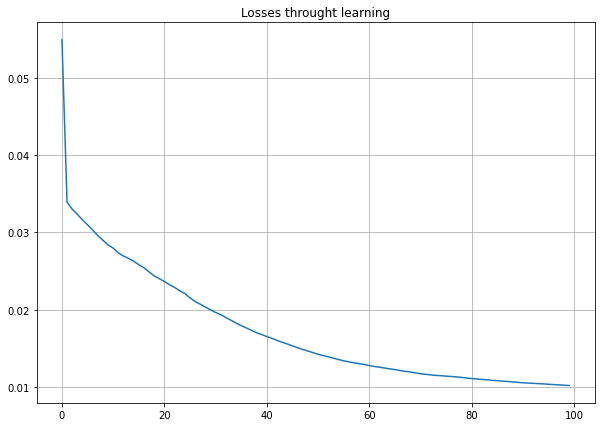

In [744]:
plt.grid()
plt.title("Losses throught learning")
plt.plot(rnn_losses)

In [745]:
y_preds = np.array(rnn.forward(X_test))

In [746]:
rnn_mse = mean_squared_error(y_preds, y_test)
rmse = np.sqrt(rnn_mse)
r2 = r2_score(y_preds, y_test)

In [747]:
print(f"MSE is {rmlp_mse}")
print(f"RMSE is {rmse}")
print(f"R2 score is {r2}")

MSE is 0.007763331218618838
RMSE is 0.08810976800910804
R2 score is 0.8022924714513731


In [701]:
class RMLP:
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.Wxh = np.random.randn(n_layers,hidden_size, input_size)
        self.Whh = np.random.randn(n_layers,hidden_size, hidden_size)
        self.Why = np.random.randn(output_size, hidden_size)
        self.bh = np.zeros((n_layers, hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        
        self.zero_grads()
        
    def zero_grads(self):
        self.dWxh = np.zeros(self.Wxh.shape)
        self.dWhh = np.zeros(self.Whh.shape)
        self.dWhy = np.zeros(self.Why.shape)
        self.dbh = np.zeros(self.bh.shape)
        self.dby = np.zeros(self.by.shape)
        
    def update_weights(self, lr):
        self.Wxh = self.Wxh - lr*self.dWxh 
        self.Whh = self.Whh - lr*self.dWhh 
        self.Why = self.Why - lr*self.dWhy
        self.bh = self.bh - lr*self.dbh 
        self.by = self.by - lr*self.dby
    
    def backward(self,y_pred, y_true):
        for i in range(y_pred.shape[0]):
            loc_grad = dmse(y_pred[i],y_true[i]) # mean?
            loc_grad = loc_grad * relu2deriv(self.ys[i]) # 
            loc_grad = loc_grad.reshape((loc_grad.shape[0], 1)) # 1,1
            self.dWhy += np.dot(loc_grad, self.h[-1].T) #
            self.dby += loc_grad
            loc_grad = np.dot(self.Why.T, loc_grad)
            print(loc_grad.shape)
            for j in range(self.xs.shape[1]-1,-1,-1):
                loct_grad = loc_grad
                for k in range(self.n_layers-1, -1, -1):
                    loct_grad = loct_grad * dtanh(self.hs[i][j][k])
                    print(loct_grad.shape)
                    print(self.hs_act[i,j+1,k].T.shape)
                    self.dWxh[k] += np.dot(loct_grad, self.hs_act[i,j+1,k].T)
                    self.dWhh[k] += np.dot(loct_grad, self.hs_act[i,j,k].T)
                    self.dbh[k] += loct_grad
                    loct_grad = np.dot(self.Whh[k].T, loc_grad)
                    
    
    
    def train(self,  X_train, y_train, epochs = 100, lr = 0.0001,batch_size = 64):
        dataset = list(zip(X_train, y_train))
        losses = []
        for epoch in tqdm(range(epochs)):
            rng.shuffle(dataset)
            ep_loss = []
            for (X_batch, y_batch) in (get_batches(dataset, batch_size)):
                preds = self.forward(X_batch)
                ep_loss.append(mse(np.array(preds), y_batch))
                self.backward(np.array(preds), y_batch)
                self.update_weights(lr)
#                 print(f"Batch error is : {ep_loss[-1]}")
                self.zero_grads()
            
            losses.append(np.array(ep_loss).mean())
            print(f"Epoch №{epoch - 1}, epoch loss is {losses[-1]}")
        return losses
    
    def forward(self, X):
        predictions = []
        self.ys = []
        self.hs = []
        self.hs_act = []
        for x in X:
            hs_cur = []
            hs_act_cur = []
            self.h = np.zeros((self.n_layers, self.hidden_size, 1))
            hs_act_cur.append(self.h)
            for x_i in x:
                hs_act_cur_layer = []
                hs_cur_layer = []
                x_i_r = x_i.reshape(self.input_size, 1)
                for j in range(self.n_layers):
                    self.h[j] = np.dot(self.Wxh[j], x_i_r) + np.dot(self.Whh[j], self.h[j]) + self.bh[j]
                    hs_cur_layer.append(self.h[j])
                    self.h[j] = np.tanh(self.h[j])
                    hs_act_cur_layer.append(self.h[j])
                hs_cur.append(hs_cur_layer)
                hs_act_cur.append(hs_act_cur_layer)
                
            self.hs.append(hs_cur)
            self.hs_act.append(hs_act_cur)
            y = np.dot(self.Why, self.h[-1]) + self.by
            self.ys.append(y)
            y = relu(y)
            predictions.append(y.item())
        self.ys = np.array(self.ys)
        self.hs = np.array(self.hs)
        self.hs_act = np.array(self.hs_act)
        self.xs = X
        return predictions

In [370]:
rmlp = RMLP(10,3,1,3)

In [371]:
losses = rmlp.train(X_train, y_train, epochs = 100, lr = 0.0003,batch_size = 64)

  1%|▊                                                                                 | 1/100 [00:08<13:32,  8.21s/it]

Epoch №-1, epoch loss is 0.023654354368410437


  2%|█▋                                                                                | 2/100 [00:16<13:14,  8.11s/it]

Epoch №0, epoch loss is 0.01810385730781136


  3%|██▍                                                                               | 3/100 [00:24<13:28,  8.34s/it]

Epoch №1, epoch loss is 0.01662612494995022


  4%|███▎                                                                              | 4/100 [00:32<13:02,  8.15s/it]

Epoch №2, epoch loss is 0.015666684766371244


  5%|████                                                                              | 5/100 [00:41<13:09,  8.32s/it]

Epoch №3, epoch loss is 0.015040522788322823


  6%|████▉                                                                             | 6/100 [00:49<13:04,  8.34s/it]

Epoch №4, epoch loss is 0.014584051116892566


  7%|█████▋                                                                            | 7/100 [00:58<13:12,  8.52s/it]

Epoch №5, epoch loss is 0.01420654389456919


  8%|██████▌                                                                           | 8/100 [01:06<12:56,  8.44s/it]

Epoch №6, epoch loss is 0.013899933591081957


  9%|███████▍                                                                          | 9/100 [01:15<12:50,  8.47s/it]

Epoch №7, epoch loss is 0.013634660611790807


 10%|████████                                                                         | 10/100 [01:24<12:47,  8.53s/it]

Epoch №8, epoch loss is 0.013384136904485797


 11%|████████▉                                                                        | 11/100 [01:33<12:52,  8.68s/it]

Epoch №9, epoch loss is 0.013155029940040005


 12%|█████████▋                                                                       | 12/100 [01:41<12:37,  8.60s/it]

Epoch №10, epoch loss is 0.01293895940824989


 13%|██████████▌                                                                      | 13/100 [01:49<12:10,  8.40s/it]

Epoch №11, epoch loss is 0.012740753425866383


 14%|███████████▎                                                                     | 14/100 [01:57<11:57,  8.35s/it]

Epoch №12, epoch loss is 0.012551838747883303


 15%|████████████▏                                                                    | 15/100 [02:06<11:48,  8.33s/it]

Epoch №13, epoch loss is 0.012376184495769263


 16%|████████████▉                                                                    | 16/100 [02:14<11:50,  8.46s/it]

Epoch №14, epoch loss is 0.012210240562049115


 17%|█████████████▊                                                                   | 17/100 [02:23<11:37,  8.40s/it]

Epoch №15, epoch loss is 0.012056813935659381


 18%|██████████████▌                                                                  | 18/100 [02:31<11:33,  8.46s/it]

Epoch №16, epoch loss is 0.011888152659394045


 19%|███████████████▍                                                                 | 19/100 [02:40<11:36,  8.60s/it]

Epoch №17, epoch loss is 0.011719794294238793


 20%|████████████████▏                                                                | 20/100 [02:50<11:51,  8.89s/it]

Epoch №18, epoch loss is 0.011537757050628825


 21%|█████████████████                                                                | 21/100 [02:58<11:21,  8.63s/it]

Epoch №19, epoch loss is 0.01135263867665975


 22%|█████████████████▊                                                               | 22/100 [03:07<11:29,  8.84s/it]

Epoch №20, epoch loss is 0.011163911164969276


 23%|██████████████████▋                                                              | 23/100 [03:16<11:33,  9.01s/it]

Epoch №21, epoch loss is 0.010948484496995776


 24%|███████████████████▍                                                             | 24/100 [03:25<11:08,  8.80s/it]

Epoch №22, epoch loss is 0.010649732907161856


 25%|████████████████████▎                                                            | 25/100 [03:33<10:54,  8.73s/it]

Epoch №23, epoch loss is 0.010226875991177931


 26%|█████████████████████                                                            | 26/100 [03:41<10:27,  8.49s/it]

Epoch №24, epoch loss is 0.009792726997928968


 27%|█████████████████████▊                                                           | 27/100 [03:49<10:10,  8.37s/it]

Epoch №25, epoch loss is 0.009385730896474015


 28%|██████████████████████▋                                                          | 28/100 [04:00<10:53,  9.07s/it]

Epoch №26, epoch loss is 0.009070941259644501


 29%|███████████████████████▍                                                         | 29/100 [04:08<10:16,  8.69s/it]

Epoch №27, epoch loss is 0.008834929970867027


 30%|████████████████████████▎                                                        | 30/100 [04:16<09:56,  8.52s/it]

Epoch №28, epoch loss is 0.008647883044812246


 31%|█████████████████████████                                                        | 31/100 [04:24<09:38,  8.39s/it]

Epoch №29, epoch loss is 0.008493292052002145


 32%|█████████████████████████▉                                                       | 32/100 [04:32<09:20,  8.25s/it]

Epoch №30, epoch loss is 0.00837123324260404


 33%|██████████████████████████▋                                                      | 33/100 [04:40<09:07,  8.17s/it]

Epoch №31, epoch loss is 0.008273698197960802


 34%|███████████████████████████▌                                                     | 34/100 [04:48<08:57,  8.15s/it]

Epoch №32, epoch loss is 0.008194621156019242


 35%|████████████████████████████▎                                                    | 35/100 [04:57<08:56,  8.25s/it]

Epoch №33, epoch loss is 0.008130345947725095


 36%|█████████████████████████████▏                                                   | 36/100 [05:05<08:53,  8.34s/it]

Epoch №34, epoch loss is 0.008075413877041459


 37%|█████████████████████████████▉                                                   | 37/100 [05:14<08:52,  8.45s/it]

Epoch №35, epoch loss is 0.008030998018539808


 38%|██████████████████████████████▊                                                  | 38/100 [05:22<08:33,  8.28s/it]

Epoch №36, epoch loss is 0.007994860547672322


 39%|███████████████████████████████▌                                                 | 39/100 [05:30<08:32,  8.40s/it]

Epoch №37, epoch loss is 0.007963910223851473


 40%|████████████████████████████████▍                                                | 40/100 [05:39<08:22,  8.38s/it]

Epoch №38, epoch loss is 0.007935022628850331


 41%|█████████████████████████████████▏                                               | 41/100 [05:47<08:15,  8.39s/it]

Epoch №39, epoch loss is 0.00791537000456006


 42%|██████████████████████████████████                                               | 42/100 [05:56<08:09,  8.44s/it]

Epoch №40, epoch loss is 0.007896600879822795


 43%|██████████████████████████████████▊                                              | 43/100 [06:06<08:41,  9.14s/it]

Epoch №41, epoch loss is 0.007879055266935577


 44%|███████████████████████████████████▋                                             | 44/100 [06:16<08:31,  9.13s/it]

Epoch №42, epoch loss is 0.007861757422313225


 45%|████████████████████████████████████▍                                            | 45/100 [06:25<08:21,  9.12s/it]

Epoch №43, epoch loss is 0.007854558567019202


 46%|█████████████████████████████████████▎                                           | 46/100 [06:33<07:58,  8.85s/it]

Epoch №44, epoch loss is 0.00783859502896681


 47%|██████████████████████████████████████                                           | 47/100 [06:40<07:29,  8.48s/it]

Epoch №45, epoch loss is 0.007831155461919873


 48%|██████████████████████████████████████▉                                          | 48/100 [06:49<07:19,  8.45s/it]

Epoch №46, epoch loss is 0.007822485229785415


 49%|███████████████████████████████████████▋                                         | 49/100 [06:57<07:10,  8.45s/it]

Epoch №47, epoch loss is 0.007815614131335287


 50%|████████████████████████████████████████▌                                        | 50/100 [07:05<06:54,  8.29s/it]

Epoch №48, epoch loss is 0.007807006593197381


 51%|█████████████████████████████████████████▎                                       | 51/100 [07:18<07:50,  9.60s/it]

Epoch №49, epoch loss is 0.007800073611163984


 52%|██████████████████████████████████████████                                       | 52/100 [07:27<07:37,  9.54s/it]

Epoch №50, epoch loss is 0.007794446084589995


 53%|██████████████████████████████████████████▉                                      | 53/100 [07:35<07:03,  9.00s/it]

Epoch №51, epoch loss is 0.007792992822251571


 54%|███████████████████████████████████████████▋                                     | 54/100 [07:47<07:36,  9.93s/it]

Epoch №52, epoch loss is 0.0077849448136261155


 55%|████████████████████████████████████████████▌                                    | 55/100 [08:04<09:01, 12.04s/it]

Epoch №53, epoch loss is 0.007782929596083135


 56%|█████████████████████████████████████████████▎                                   | 56/100 [08:13<08:13, 11.23s/it]

Epoch №54, epoch loss is 0.0077778283524973044


 57%|██████████████████████████████████████████████▏                                  | 57/100 [08:23<07:38, 10.66s/it]

Epoch №55, epoch loss is 0.00777384597492218


 58%|██████████████████████████████████████████████▉                                  | 58/100 [08:32<07:06, 10.15s/it]

Epoch №56, epoch loss is 0.007767906121326676


 59%|███████████████████████████████████████████████▊                                 | 59/100 [08:40<06:32,  9.56s/it]

Epoch №57, epoch loss is 0.00776586218449565


 60%|████████████████████████████████████████████████▌                                | 60/100 [08:48<06:03,  9.10s/it]

Epoch №58, epoch loss is 0.007762576338213172


 61%|█████████████████████████████████████████████████▍                               | 61/100 [08:57<05:55,  9.11s/it]

Epoch №59, epoch loss is 0.007759271650192087


 62%|██████████████████████████████████████████████████▏                              | 62/100 [09:06<05:39,  8.93s/it]

Epoch №60, epoch loss is 0.007757925808035274


 63%|███████████████████████████████████████████████████                              | 63/100 [09:18<06:08,  9.96s/it]

Epoch №61, epoch loss is 0.007754288259509698


 64%|███████████████████████████████████████████████████▊                             | 64/100 [09:33<06:54, 11.50s/it]

Epoch №62, epoch loss is 0.007747492379516497


 65%|████████████████████████████████████████████████████▋                            | 65/100 [09:48<07:20, 12.59s/it]

Epoch №63, epoch loss is 0.007749656534417569


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [10:01<07:07, 12.56s/it]

Epoch №64, epoch loss is 0.00774104067132153


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [10:12<06:41, 12.16s/it]

Epoch №65, epoch loss is 0.00774013524856468


 68%|███████████████████████████████████████████████████████                          | 68/100 [10:23<06:22, 11.95s/it]

Epoch №66, epoch loss is 0.00773694076034409


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [10:42<07:09, 13.87s/it]

Epoch №67, epoch loss is 0.0077371156206701335


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [10:53<06:33, 13.10s/it]

Epoch №68, epoch loss is 0.007735663703145305


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [11:01<05:39, 11.70s/it]

Epoch №69, epoch loss is 0.007732885390781676


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [11:11<05:06, 10.93s/it]

Epoch №70, epoch loss is 0.007730055757495829


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [11:20<04:41, 10.42s/it]

Epoch №71, epoch loss is 0.007728311987659183


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [11:30<04:26, 10.24s/it]

Epoch №72, epoch loss is 0.00772447082408361


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [11:40<04:16, 10.27s/it]

Epoch №73, epoch loss is 0.007725070554148467


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [11:51<04:09, 10.39s/it]

Epoch №74, epoch loss is 0.007721954296261718


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [12:01<03:56, 10.30s/it]

Epoch №75, epoch loss is 0.007719147771443811


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [12:09<03:31,  9.63s/it]

Epoch №76, epoch loss is 0.007717550822947895


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [12:17<03:14,  9.25s/it]

Epoch №77, epoch loss is 0.007713068195910409


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [12:26<03:03,  9.16s/it]

Epoch №78, epoch loss is 0.007710904642049803


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [12:36<03:00,  9.49s/it]

Epoch №79, epoch loss is 0.0077103703824763095


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [12:45<02:48,  9.36s/it]

Epoch №80, epoch loss is 0.0077088320010075834


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [13:00<03:04, 10.83s/it]

Epoch №81, epoch loss is 0.0077058549542942546


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [13:12<02:59, 11.25s/it]

Epoch №82, epoch loss is 0.007705193016706422


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [13:21<02:37, 10.53s/it]

Epoch №83, epoch loss is 0.007703668465470316


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [13:28<02:13,  9.57s/it]

Epoch №84, epoch loss is 0.007701728334442969


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [13:36<01:56,  8.93s/it]

Epoch №85, epoch loss is 0.007699835469101863


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [13:43<01:43,  8.64s/it]

Epoch №86, epoch loss is 0.00769737397780611


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [13:52<01:33,  8.52s/it]

Epoch №87, epoch loss is 0.007695004801879377


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [14:00<01:23,  8.38s/it]

Epoch №88, epoch loss is 0.007693638809420522


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [14:07<01:13,  8.17s/it]

Epoch №89, epoch loss is 0.007690904317549376


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [14:15<01:04,  8.08s/it]

Epoch №90, epoch loss is 0.00769159078053519


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [14:23<00:55,  7.95s/it]

Epoch №91, epoch loss is 0.007687522846572569


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [14:31<00:47,  7.92s/it]

Epoch №92, epoch loss is 0.007686280266049887


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [14:38<00:39,  7.83s/it]

Epoch №93, epoch loss is 0.007684189484990132


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [14:46<00:30,  7.75s/it]

Epoch №94, epoch loss is 0.0076828142880135805


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [14:54<00:23,  7.70s/it]

Epoch №95, epoch loss is 0.0076794824165138465


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [15:02<00:15,  7.78s/it]

Epoch №96, epoch loss is 0.007679231361234233


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [15:09<00:07,  7.76s/it]

Epoch №97, epoch loss is 0.0076788972773098345


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:17<00:00,  9.17s/it]

Epoch №98, epoch loss is 0.007675739908848669


In [390]:
from matplotlib.pyplot import figure
plt.rcParams ['figure.figsize'] = [10, 7]

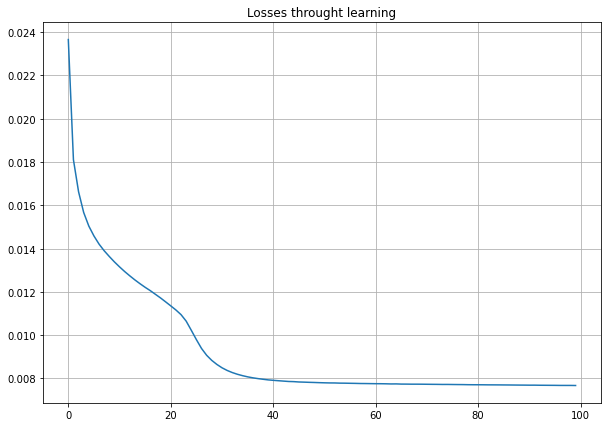

In [392]:
plt.grid()
plt.title("Losses throught learning")
plt.plot(losses)

In [403]:
y_preds = np.array(rmlp.forward(X_test))

In [407]:
from sklearn.metrics import mean_squared_error, r2_score

In [410]:
rmlp_mse = mean_squared_error(y_preds, y_test)
rmse = np.sqrt(rmlp_mse)
r2 = r2_score(y_preds, y_test)

In [411]:
print(f"MSE is {rmlp_mse}")
print(f"RMSE is {rmse}")
print(f"R2 score is {r2}")

MSE is 0.006031032755514394
RMSE is 0.07765972415296357
R2 score is 0.8424321767292989


In [544]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Init params
        self.Wxf = np.random.randn(hidden_size, input_size)
        self.Whf = np.random.randn(hidden_size, hidden_size)
        
        self.Wxi = np.random.randn(hidden_size, input_size)
        self.Whi = np.random.randn(hidden_size, hidden_size)
        
        self.Wxc = np.random.randn(hidden_size, input_size)
        self.Whc = np.random.randn(hidden_size, hidden_size)
        
        self.Wxo = np.random.randn(hidden_size, input_size)
        self.Who = np.random.randn(hidden_size, hidden_size)
        
        self.Why = np.random.randn(output_size, hidden_size)
        self.bi = np.zeros((hidden_size, 1))
        self.bf = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        
        
        self.zero_grads()
        
    def zero_grads(self):

        self.dWxf = np.zeros(self.Wxf.shape)
        self.dWhf = np.zeros(self.Whf.shape)

        self.dWxi = np.zeros(self.Wxi.shape)
        self.dWhi = np.zeros(self.Whi.shape)

        self.dWxc = np.zeros(self.Wxc.shape)
        self.dWhc = np.zeros(self.Whc.shape)

        self.dWxo = np.zeros(self.Wxo.shape)
        self.dWho = np.zeros(self.Who.shape)

        self.dWhy = np.zeros(self.Why.shape)

        self.dbi = np.zeros(self.bi.shape)
        self.dbf = np.zeros(self.bf.shape)
        self.dbc = np.zeros(self.bc.shape)
        self.dbo = np.zeros(self.bo.shape)
        self.dby = np.zeros(self.by.shape)
        
    def update_weights(self, lr):

        self.Wxf = self.Wxf - lr*self.dWxf
        self.Whf = self.Whf - lr*self.dWhf

        self.Wxi = self.Wxi - lr*self.dWxi
        self.Whi = self.Whi - lr*self.dWhi

        self.Wxc = self.Wxc - lr*self.dWxc
        self.Whc = self.Whc - lr*self.dWhc

        self.Wxo = self.Wxo - lr*self.dWxo
        self.Who = self.Who - lr*self.dWho

        self.Why = self.Why - lr*self.dWhy
        self.bi = self.bi - lr*self.dbi
        self.bf = self.bf - lr*self.dbf
        self.bc = self.bc - lr*self.dbc
        self.bo = self.bo - lr*self.dbo
        self.by = self.by - lr*self.dby

    
    def backward(self, y_pred, y_true):
        for i in range(y_pred.shape[0]):
            loc_grad = dmse(y_pred[i],y_true[i])
            loc_grad = loc_grad * relu2deriv(self.ys[i]) 
            loc_grad = loc_grad.reshape((loc_grad.shape[0], 1)) 
            self.dWhy += np.dot(loc_grad, self.h.T) 
            self.dby += loc_grad
            dht = np.dot(self.Why.T, loc_grad)
            for j in range(self.xs.shape[1]-1,-1,-1):
                dct = dht * self.os[i][j] * dtanh(self.cts[i][j + 1])
                dcand_t = dct * self.its[i][j]
                dot = dht * tanh(self.cts[i][j + 1])
                dit = dct*self.cands[i][j]
                dft = dct*self.cts[i][j] ## add exceptions.. to cts and hts
                
                self.dWxf += np.dot(dft * self.fts[i][j] * (1 - self.fts[i][j]), self.xs[i][j].reshape((self.xs[i][j].shape[0],1)).T)
                self.dWhf += np.dot(dft * self.fts[i][j] * (1 - self.fts[i][j]), self.hs[i][j].T)
                self.dbf += dft * self.fts[i][j] * (1 - self.fts[i][j])
                
                self.dWxi += np.dot(dit * self.its[i][j] * (1 - self.its[i][j]), self.xs[i][j].reshape((self.xs[i][j].shape[0],1)).T)
                self.dWhi += np.dot(dit * self.its[i][j] * (1 - self.its[i][j]), self.hs[i][j].T)
                self.dbi += dft * self.its[i][j] * (1 - self.its[i][j])
                
                self.dWxo += np.dot(dot * self.os[i][j] * (1 - self.os[i][j]), self.xs[i][j].reshape((self.xs[i][j].shape[0],1)).T)
                self.dWho += np.dot(dot * self.os[i][j] * (1 - self.os[i][j]), self.hs[i][j].T)
                self.dbo += dot * self.os[i][j] * (1 - self.os[i][j])
                
                self.dWxc += np.dot(dcand_t * (1 - self.cands[i][j]**2), self.xs[i][j].reshape((self.xs[i][j].shape[0],1)).reshape((self.xs[i][j].shape[0],1)).T)
                self.dWhc += np.dot(dcand_t * (1 - self.cands[i][j]**2), self.hs[i][j].T)
                self.dbc += dcand_t * (1 - self.cands[i][j]**2)
                
        
    def train(self,  X_train, y_train, epochs = 100, lr = 0.0001,batch_size = 64):
        dataset = list(zip(X_train, y_train))
        losses = []
        for epoch in tqdm(range(epochs)):
            rng.shuffle(dataset)
            ep_loss = []
            for (X_batch, y_batch) in (get_batches(dataset, batch_size)):
                preds = self.forward(X_batch)
                ep_loss.append(mse(np.array(preds), y_batch))
                self.backward(np.array(preds), y_batch)
                self.update_weights(lr)
#                 print(f"Batch error is : {ep_loss[-1]}")
                self.zero_grads()
            
            losses.append(np.array(ep_loss).mean())
            print(f"Epoch №{epoch + 1}, epoch loss is {losses[-1]}")
        return losses
    
    def forward(self, X):
        predictions = []
        self.ys = []
        self.hs = []
        self.cts = []
        self.cands = []
        self.its = []
        self.os = []
        self.fts = []
        for x in X:
            hs_cur = []
            cts_cur = []
            its_cur = []
            cand_cur = []
            os_cur = []
            fts_cur = []

            self.h = np.zeros((self.hidden_size, 1))
            self.c = np.zeros((self.hidden_size, 1))
            hs_cur.append(self.h)
            cts_cur.append(self.c)
            for x_i in x:
                x_i_r = x_i.reshape(self.input_size, 1)

                # LSTM Gates
                self.f_gate = sigmoid(np.dot(self.Wxf, x_i_r) + np.dot(self.Whf, self.h) + self.bf)
                self.i_gate = sigmoid(np.dot(self.Wxi, x_i_r) + np.dot(self.Whi, self.h) + self.bi)
                self.o_gate = sigmoid(np.dot(self.Wxo, x_i_r) + np.dot(self.Who, self.h) + self.bo)
                os_cur.append(self.o_gate)
                its_cur.append(self.i_gate)
                fts_cur.append(self.f_gate)
                
                # LSTM States
                self.c_candidate = tanh(np.dot(self.Wxc, x_i_r) + np.dot(self.Whc, self.h) + self.bc)
                cand_cur.append(self.c_candidate)
                self.c = self.f_gate * self.c + self.i_gate * self.c_candidate
                cts_cur.append(self.c)
                self.h = self.o_gate * tanh(self.c)

                hs_cur.append(self.h)

            self.hs.append(hs_cur)
            self.os.append(os_cur)
            self.cts.append(cts_cur)
            self.its.append(its_cur)
            self.cands.append(cand_cur)
            self.fts.append(fts_cur)
            y = np.dot(self.Why, self.h) + self.by
            self.ys.append(y)
            y = relu(y)
            predictions.append(y.item())
        self.ys = np.array(self.ys)
        self.hs = np.array(self.hs)
        self.cts = np.array(self.cts)
        self.its = np.array(self.its)
        self.cands = np.array(self.cands)
        self.os = np.array(self.os)
        self.fts = np.array(self.fts)
        self.xs = X
        return predictions
        

In [550]:
lstm = LSTM(10,3,1)

In [553]:
losses_lstm = lstm.train(X_train, y_train, epochs = 100, lr = 0.0005,batch_size = 64)

  1%|▊                                                                                 | 1/100 [00:32<53:42, 32.55s/it]

Epoch №1, epoch loss is 0.07763593482718918


  2%|█▋                                                                                | 2/100 [01:05<53:35, 32.81s/it]

Epoch №2, epoch loss is 0.05265852278272192


  3%|██▍                                                                               | 3/100 [01:44<55:42, 34.46s/it]

Epoch №3, epoch loss is 0.04054665426449924


  4%|███▎                                                                              | 4/100 [02:28<59:43, 37.32s/it]

Epoch №4, epoch loss is 0.024010183938388732


  5%|████                                                                              | 5/100 [03:01<57:02, 36.03s/it]

Epoch №5, epoch loss is 0.017127903265645485


  6%|████▉                                                                             | 6/100 [03:34<54:55, 35.06s/it]

Epoch №6, epoch loss is 0.01401521722053757


  7%|█████▋                                                                            | 7/100 [04:07<53:24, 34.45s/it]

Epoch №7, epoch loss is 0.012567508780196739


  8%|██████▌                                                                           | 8/100 [04:40<52:09, 34.02s/it]

Epoch №8, epoch loss is 0.011646498899035478


  9%|███████▍                                                                          | 9/100 [05:13<51:13, 33.78s/it]

Epoch №9, epoch loss is 0.011039527970919465


 10%|████████                                                                         | 10/100 [05:46<50:11, 33.46s/it]

Epoch №10, epoch loss is 0.010637231731518515


 11%|████████▉                                                                        | 11/100 [06:18<49:20, 33.26s/it]

Epoch №11, epoch loss is 0.010326063135915905


 12%|█████████▋                                                                       | 12/100 [06:52<48:45, 33.25s/it]

Epoch №12, epoch loss is 0.010069453781615204


 13%|██████████▌                                                                      | 13/100 [07:28<49:38, 34.24s/it]

Epoch №13, epoch loss is 0.009879200822165878


 14%|███████████▎                                                                     | 14/100 [08:01<48:29, 33.83s/it]

Epoch №14, epoch loss is 0.009740600446739267


 15%|████████████▏                                                                    | 15/100 [08:33<47:21, 33.42s/it]

Epoch №15, epoch loss is 0.009630001795321896


 16%|████████████▉                                                                    | 16/100 [09:06<46:30, 33.21s/it]

Epoch №16, epoch loss is 0.009537927453069904


 17%|█████████████▊                                                                   | 17/100 [09:42<46:54, 33.92s/it]

Epoch №17, epoch loss is 0.009461609569687342


 18%|██████████████▌                                                                  | 18/100 [10:15<46:03, 33.70s/it]

Epoch №18, epoch loss is 0.009389554831377501


 19%|███████████████▍                                                                 | 19/100 [10:49<45:41, 33.84s/it]

Epoch №19, epoch loss is 0.009334394515222397


 20%|████████████████▏                                                                | 20/100 [11:23<45:11, 33.89s/it]

Epoch №20, epoch loss is 0.009280284377171629


 21%|█████████████████                                                                | 21/100 [12:09<49:29, 37.58s/it]

Epoch №21, epoch loss is 0.009227904171668652


 22%|█████████████████▊                                                               | 22/100 [12:57<52:50, 40.65s/it]

Epoch №22, epoch loss is 0.009182013338744898


 23%|██████████████████▋                                                              | 23/100 [13:37<51:43, 40.30s/it]

Epoch №23, epoch loss is 0.009134619122370366


 24%|███████████████████▍                                                             | 24/100 [14:12<49:06, 38.76s/it]

Epoch №24, epoch loss is 0.00909399393369714


 25%|████████████████████▎                                                            | 25/100 [14:44<46:05, 36.87s/it]

Epoch №25, epoch loss is 0.009055930722402664


 26%|█████████████████████                                                            | 26/100 [15:17<44:02, 35.71s/it]

Epoch №26, epoch loss is 0.009018253779934728


 27%|█████████████████████▊                                                           | 27/100 [15:50<42:31, 34.96s/it]

Epoch №27, epoch loss is 0.008981485590595601


 28%|██████████████████████▋                                                          | 28/100 [16:23<41:13, 34.35s/it]

Epoch №28, epoch loss is 0.008948838932633239


 29%|███████████████████████▍                                                         | 29/100 [16:56<39:59, 33.80s/it]

Epoch №29, epoch loss is 0.008913383046307122


 30%|████████████████████████▎                                                        | 30/100 [17:29<39:20, 33.72s/it]

Epoch №30, epoch loss is 0.008884467519439745


 31%|█████████████████████████                                                        | 31/100 [18:04<38:55, 33.85s/it]

Epoch №31, epoch loss is 0.008857415515620868


 32%|█████████████████████████▉                                                       | 32/100 [18:36<37:55, 33.47s/it]

Epoch №32, epoch loss is 0.008830152577486101


 33%|██████████████████████████▋                                                      | 33/100 [19:09<37:05, 33.21s/it]

Epoch №33, epoch loss is 0.008805687934530316


 34%|███████████████████████████▌                                                     | 34/100 [19:41<36:18, 33.01s/it]

Epoch №34, epoch loss is 0.008779898668140721


 35%|████████████████████████████▎                                                    | 35/100 [20:14<35:31, 32.79s/it]

Epoch №35, epoch loss is 0.008755909922571883


 36%|█████████████████████████████▏                                                   | 36/100 [20:48<35:21, 33.15s/it]

Epoch №36, epoch loss is 0.008735358140999556


 37%|█████████████████████████████▉                                                   | 37/100 [21:21<34:46, 33.13s/it]

Epoch №37, epoch loss is 0.008711418958908198


 38%|██████████████████████████████▊                                                  | 38/100 [21:53<34:01, 32.92s/it]

Epoch №38, epoch loss is 0.008685500043899898


 39%|███████████████████████████████▌                                                 | 39/100 [22:26<33:24, 32.86s/it]

Epoch №39, epoch loss is 0.00866280642140605


 40%|████████████████████████████████▍                                                | 40/100 [22:58<32:39, 32.66s/it]

Epoch №40, epoch loss is 0.008646653299739694


 41%|█████████████████████████████████▏                                               | 41/100 [23:31<32:06, 32.66s/it]

Epoch №41, epoch loss is 0.008621019949164888


 42%|██████████████████████████████████                                               | 42/100 [24:03<31:33, 32.64s/it]

Epoch №42, epoch loss is 0.008607444450072107


 43%|██████████████████████████████████▊                                              | 43/100 [24:36<31:05, 32.72s/it]

Epoch №43, epoch loss is 0.008589377248320483


 44%|███████████████████████████████████▋                                             | 44/100 [25:12<31:23, 33.63s/it]

Epoch №44, epoch loss is 0.008567544119406


 45%|████████████████████████████████████▍                                            | 45/100 [25:45<30:34, 33.35s/it]

Epoch №45, epoch loss is 0.008549758377658949


 46%|█████████████████████████████████████▎                                           | 46/100 [26:17<29:48, 33.11s/it]

Epoch №46, epoch loss is 0.008530686303392352


 47%|██████████████████████████████████████                                           | 47/100 [26:50<29:05, 32.93s/it]

Epoch №47, epoch loss is 0.008514147319369635


 48%|██████████████████████████████████████▉                                          | 48/100 [27:23<28:39, 33.06s/it]

Epoch №48, epoch loss is 0.008495515595413675


 49%|███████████████████████████████████████▋                                         | 49/100 [27:56<28:01, 32.97s/it]

Epoch №49, epoch loss is 0.00847622376140457


 50%|████████████████████████████████████████▌                                        | 50/100 [28:28<27:22, 32.86s/it]

Epoch №50, epoch loss is 0.008456503934592324


 51%|█████████████████████████████████████████▎                                       | 51/100 [29:01<26:40, 32.66s/it]

Epoch №51, epoch loss is 0.008437794856809783


 52%|██████████████████████████████████████████                                       | 52/100 [29:33<26:07, 32.66s/it]

Epoch №52, epoch loss is 0.008420217561815178


 53%|██████████████████████████████████████████▉                                      | 53/100 [30:06<25:32, 32.61s/it]

Epoch №53, epoch loss is 0.008403693925858408


 54%|███████████████████████████████████████████▋                                     | 54/100 [30:38<24:59, 32.59s/it]

Epoch №54, epoch loss is 0.00838699117935937


 55%|████████████████████████████████████████████▌                                    | 55/100 [31:10<24:20, 32.46s/it]

Epoch №55, epoch loss is 0.008370090833895723


 56%|█████████████████████████████████████████████▎                                   | 56/100 [31:43<23:51, 32.54s/it]

Epoch №56, epoch loss is 0.008353203927720725


 57%|██████████████████████████████████████████████▏                                  | 57/100 [32:15<23:12, 32.39s/it]

Epoch №57, epoch loss is 0.008333119616935175


 58%|██████████████████████████████████████████████▉                                  | 58/100 [32:48<22:45, 32.52s/it]

Epoch №58, epoch loss is 0.008315538000313104


 59%|███████████████████████████████████████████████▊                                 | 59/100 [33:21<22:20, 32.70s/it]

Epoch №59, epoch loss is 0.008306877009981414


 60%|████████████████████████████████████████████████▌                                | 60/100 [33:53<21:42, 32.56s/it]

Epoch №60, epoch loss is 0.00829341145248643


 61%|█████████████████████████████████████████████████▍                               | 61/100 [34:26<21:10, 32.57s/it]

Epoch №61, epoch loss is 0.008276709339227256


 62%|██████████████████████████████████████████████████▏                              | 62/100 [34:58<20:34, 32.50s/it]

Epoch №62, epoch loss is 0.00826103221710168


 63%|███████████████████████████████████████████████████                              | 63/100 [35:31<20:07, 32.63s/it]

Epoch №63, epoch loss is 0.008245123263420629


 64%|███████████████████████████████████████████████████▊                             | 64/100 [36:04<19:33, 32.59s/it]

Epoch №64, epoch loss is 0.00823049786643111


 65%|████████████████████████████████████████████████████▋                            | 65/100 [36:36<19:00, 32.58s/it]

Epoch №65, epoch loss is 0.008215615256075616


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [37:09<18:25, 32.52s/it]

Epoch №66, epoch loss is 0.008202789860881078


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [37:42<18:02, 32.80s/it]

Epoch №67, epoch loss is 0.0081874217944198


 68%|███████████████████████████████████████████████████████                          | 68/100 [38:14<17:24, 32.63s/it]

Epoch №68, epoch loss is 0.008177163313030207


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [38:47<16:52, 32.67s/it]

Epoch №69, epoch loss is 0.008160587251520943


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [39:20<16:19, 32.66s/it]

Epoch №70, epoch loss is 0.008148959882091373


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [39:53<15:48, 32.72s/it]

Epoch №71, epoch loss is 0.008139082365893995


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [40:25<15:14, 32.67s/it]

Epoch №72, epoch loss is 0.008126938392655917


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [40:58<14:40, 32.60s/it]

Epoch №73, epoch loss is 0.008116956118173885


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [41:30<14:08, 32.62s/it]

Epoch №74, epoch loss is 0.0081055766421538


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [42:02<13:32, 32.49s/it]

Epoch №75, epoch loss is 0.008097034955831469


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [42:35<13:00, 32.54s/it]

Epoch №76, epoch loss is 0.00808444376250771


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [43:08<12:27, 32.52s/it]

Epoch №77, epoch loss is 0.008072466607710098


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [43:41<11:58, 32.67s/it]

Epoch №78, epoch loss is 0.008062835813146964


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [44:13<11:25, 32.66s/it]

Epoch №79, epoch loss is 0.008051773269646267


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [44:46<10:52, 32.63s/it]

Epoch №80, epoch loss is 0.008039678407119088


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [45:19<10:25, 32.92s/it]

Epoch №81, epoch loss is 0.008030850673308559


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [45:53<09:58, 33.24s/it]

Epoch №82, epoch loss is 0.008019087424140139


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [46:47<11:09, 39.36s/it]

Epoch №83, epoch loss is 0.008007380183676046


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [47:31<10:53, 40.86s/it]

Epoch №84, epoch loss is 0.007997244184050492


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [48:18<10:38, 42.58s/it]

Epoch №85, epoch loss is 0.007990550174460143


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [49:02<10:02, 43.02s/it]

Epoch №86, epoch loss is 0.007979506361916789


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [49:36<08:43, 40.30s/it]

Epoch №87, epoch loss is 0.00796901751261364


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [50:08<07:35, 37.95s/it]

Epoch №88, epoch loss is 0.007956465926916815


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [50:41<06:39, 36.28s/it]

Epoch №89, epoch loss is 0.007945817646523556


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [51:14<05:53, 35.38s/it]

Epoch №90, epoch loss is 0.007937078345731936


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [51:47<05:11, 34.59s/it]

Epoch №91, epoch loss is 0.007924027808324009


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [52:20<04:32, 34.04s/it]

Epoch №92, epoch loss is 0.007917272726645087


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [52:52<03:54, 33.55s/it]

Epoch №93, epoch loss is 0.00790831077517441


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [53:40<03:46, 37.80s/it]

Epoch №94, epoch loss is 0.00790083203792836


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [54:17<03:08, 37.67s/it]

Epoch №95, epoch loss is 0.007890160416621795


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [54:53<02:28, 37.23s/it]

Epoch №96, epoch loss is 0.007880598219715903


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [55:28<01:49, 36.45s/it]

Epoch №97, epoch loss is 0.007871673580269594


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [56:04<01:12, 36.26s/it]

Epoch №98, epoch loss is 0.00786297627063081


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [56:40<00:36, 36.38s/it]

Epoch №99, epoch loss is 0.007856989196636374


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [57:16<00:00, 34.36s/it]

Epoch №100, epoch loss is 0.007847521530743619


In [559]:
losses_lstm_2 = lstm.train(X_train, y_train, epochs = 100, lr = 0.0005,batch_size = 64)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\vepif\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
  1%|▊                                                                                 | 1/100 [00:35<58:01, 35.17s/it]

Epoch №1, epoch loss is 0.007832998489825589


  2%|█▋                                                                                | 2/100 [01:07<56:11, 34.40s/it]

Epoch №2, epoch loss is 0.007833415018140737


  3%|██▍                                                                               | 3/100 [01:42<55:32, 34.35s/it]

Epoch №3, epoch loss is 0.00782646787902667


  4%|███▎                                                                              | 4/100 [02:18<55:50, 34.90s/it]

Epoch №4, epoch loss is 0.007813242147049392


  5%|████                                                                              | 5/100 [02:53<55:16, 34.91s/it]

Epoch №5, epoch loss is 0.007808464035848449


  6%|████▉                                                                             | 6/100 [03:26<54:02, 34.50s/it]

Epoch №6, epoch loss is 0.0078031670167300485


  7%|█████▋                                                                            | 7/100 [04:00<53:10, 34.31s/it]

Epoch №7, epoch loss is 0.007795911715408708


  8%|██████▌                                                                           | 8/100 [04:39<54:34, 35.60s/it]

Epoch №8, epoch loss is 0.007786595546142255


  9%|███████▍                                                                          | 9/100 [05:21<56:58, 37.56s/it]

Epoch №9, epoch loss is 0.007780233909614192


 10%|████████                                                                         | 10/100 [06:01<57:38, 38.42s/it]

Epoch №10, epoch loss is 0.00777123601810592


 11%|████████▉                                                                        | 11/100 [06:39<56:35, 38.15s/it]

Epoch №11, epoch loss is 0.0077653375071688995


 12%|█████████▋                                                                       | 12/100 [07:16<55:39, 37.95s/it]

Epoch №12, epoch loss is 0.007758601014810514


 13%|██████████▌                                                                      | 13/100 [07:56<55:59, 38.61s/it]

Epoch №13, epoch loss is 0.007751125901430803


 14%|███████████▎                                                                     | 14/100 [08:32<54:09, 37.79s/it]

Epoch №14, epoch loss is 0.007749090456583744


 15%|████████████▏                                                                    | 15/100 [09:09<53:11, 37.55s/it]

Epoch №15, epoch loss is 0.007741620614925953


 16%|████████████▉                                                                    | 16/100 [09:44<51:17, 36.63s/it]

Epoch №16, epoch loss is 0.007736539147585604


 17%|█████████████▊                                                                   | 17/100 [10:17<49:17, 35.63s/it]

Epoch №17, epoch loss is 0.007728752747182641


 18%|██████████████▌                                                                  | 18/100 [10:53<48:44, 35.66s/it]

Epoch №18, epoch loss is 0.007724285505609824


 19%|███████████████▍                                                                 | 19/100 [11:30<48:45, 36.11s/it]

Epoch №19, epoch loss is 0.007721265190937232


 20%|████████████████▏                                                                | 20/100 [12:07<48:21, 36.27s/it]

Epoch №20, epoch loss is 0.007716445478290628


 21%|█████████████████                                                                | 21/100 [12:42<47:14, 35.89s/it]

Epoch №21, epoch loss is 0.007711332384290258


 22%|█████████████████▊                                                               | 22/100 [13:16<46:08, 35.50s/it]

Epoch №22, epoch loss is 0.007706079563258015


 23%|██████████████████▋                                                              | 23/100 [13:55<46:53, 36.54s/it]

Epoch №23, epoch loss is 0.007699080674904859


 24%|███████████████████▍                                                             | 24/100 [14:31<46:03, 36.36s/it]

Epoch №24, epoch loss is 0.007694094837850019


 25%|████████████████████▎                                                            | 25/100 [15:06<44:50, 35.88s/it]

Epoch №25, epoch loss is 0.007689570883566729


 26%|█████████████████████                                                            | 26/100 [15:59<50:30, 40.95s/it]

Epoch №26, epoch loss is 0.007684453528235771


 27%|█████████████████████▊                                                           | 27/100 [16:50<53:31, 43.99s/it]

Epoch №27, epoch loss is 0.007678430922597779


 28%|██████████████████████▋                                                          | 28/100 [17:33<52:32, 43.78s/it]

Epoch №28, epoch loss is 0.007674122215026773


 29%|███████████████████████▍                                                         | 29/100 [18:22<53:48, 45.47s/it]

Epoch №29, epoch loss is 0.007672311846534781


 30%|████████████████████████▎                                                        | 30/100 [19:14<55:21, 47.46s/it]

Epoch №30, epoch loss is 0.007666969538515225


 31%|█████████████████████████                                                        | 31/100 [20:00<53:47, 46.77s/it]

Epoch №31, epoch loss is 0.007660858809129852


 32%|█████████████████████████▉                                                       | 32/100 [20:49<53:50, 47.51s/it]

Epoch №32, epoch loss is 0.007656309171871243


 33%|██████████████████████████▋                                                      | 33/100 [21:29<50:31, 45.25s/it]

Epoch №33, epoch loss is 0.007650576161643603


 34%|███████████████████████████▌                                                     | 34/100 [22:12<49:12, 44.74s/it]

Epoch №34, epoch loss is 0.0076456326671328284


 35%|████████████████████████████▎                                                    | 35/100 [23:00<49:32, 45.73s/it]

Epoch №35, epoch loss is 0.007642137622507611


 36%|█████████████████████████████▏                                                   | 36/100 [23:43<47:46, 44.78s/it]

Epoch №36, epoch loss is 0.007636505336570312


 37%|█████████████████████████████▉                                                   | 37/100 [24:32<48:29, 46.17s/it]

Epoch №37, epoch loss is 0.007632067887563751


 38%|██████████████████████████████▊                                                  | 38/100 [25:28<50:29, 48.87s/it]

Epoch №38, epoch loss is 0.007627149029845224


 39%|███████████████████████████████▌                                                 | 39/100 [26:18<50:13, 49.39s/it]

Epoch №39, epoch loss is 0.007621764971393963


 40%|████████████████████████████████▍                                                | 40/100 [27:04<48:17, 48.29s/it]

Epoch №40, epoch loss is 0.007618298497887558


 41%|█████████████████████████████████▏                                               | 41/100 [27:53<47:46, 48.59s/it]

Epoch №41, epoch loss is 0.007613175011663796


 42%|██████████████████████████████████                                               | 42/100 [28:46<48:17, 49.95s/it]

Epoch №42, epoch loss is 0.007610651231873527


 43%|██████████████████████████████████▊                                              | 43/100 [29:35<46:57, 49.42s/it]

Epoch №43, epoch loss is 0.007604067428653299


 44%|███████████████████████████████████▋                                             | 44/100 [30:19<44:38, 47.83s/it]

Epoch №44, epoch loss is 0.007603367797801868


 45%|████████████████████████████████████▍                                            | 45/100 [31:00<41:59, 45.81s/it]

Epoch №45, epoch loss is 0.007598240883320983


 46%|█████████████████████████████████████▎                                           | 46/100 [31:42<40:23, 44.88s/it]

Epoch №46, epoch loss is 0.007596197993367127


 47%|██████████████████████████████████████                                           | 47/100 [32:23<38:34, 43.68s/it]

Epoch №47, epoch loss is 0.007591824919967423


 48%|██████████████████████████████████████▉                                          | 48/100 [33:06<37:32, 43.31s/it]

Epoch №48, epoch loss is 0.0075898485900259514


 49%|███████████████████████████████████████▋                                         | 49/100 [33:50<37:07, 43.67s/it]

Epoch №49, epoch loss is 0.007582358377697335


 50%|████████████████████████████████████████▌                                        | 50/100 [34:28<34:58, 41.97s/it]

Epoch №50, epoch loss is 0.0075796073294622495


 51%|█████████████████████████████████████████▎                                       | 51/100 [35:11<34:31, 42.27s/it]

Epoch №51, epoch loss is 0.007573921597980048


 52%|██████████████████████████████████████████                                       | 52/100 [36:12<38:08, 47.67s/it]

Epoch №52, epoch loss is 0.0075733790914818055


 53%|██████████████████████████████████████████▉                                      | 53/100 [36:59<37:17, 47.61s/it]

Epoch №53, epoch loss is 0.007573090862062323


 54%|███████████████████████████████████████████▋                                     | 54/100 [37:52<37:41, 49.17s/it]

Epoch №54, epoch loss is 0.007569103364323477


 55%|████████████████████████████████████████████▌                                    | 55/100 [38:38<36:18, 48.42s/it]

Epoch №55, epoch loss is 0.007566261058540043


 56%|█████████████████████████████████████████████▎                                   | 56/100 [39:27<35:26, 48.33s/it]

Epoch №56, epoch loss is 0.007566265090565424


 57%|██████████████████████████████████████████████▏                                  | 57/100 [40:14<34:29, 48.14s/it]

Epoch №57, epoch loss is 0.007559280990301597


 58%|██████████████████████████████████████████████▉                                  | 58/100 [41:01<33:24, 47.72s/it]

Epoch №58, epoch loss is 0.007558538460061837


 59%|███████████████████████████████████████████████▊                                 | 59/100 [41:47<32:20, 47.33s/it]

Epoch №59, epoch loss is 0.007554385742098088


 60%|████████████████████████████████████████████████▌                                | 60/100 [42:28<30:07, 45.18s/it]

Epoch №60, epoch loss is 0.007547674927223646


 61%|█████████████████████████████████████████████████▍                               | 61/100 [43:15<29:48, 45.86s/it]

Epoch №61, epoch loss is 0.0075469274659722635


 62%|██████████████████████████████████████████████████▏                              | 62/100 [44:01<28:59, 45.78s/it]

Epoch №62, epoch loss is 0.007545006175527985


 63%|███████████████████████████████████████████████████                              | 63/100 [44:49<28:41, 46.52s/it]

Epoch №63, epoch loss is 0.007540320476417387


 64%|███████████████████████████████████████████████████▊                             | 64/100 [45:36<27:59, 46.65s/it]

Epoch №64, epoch loss is 0.007537461038939678


 65%|████████████████████████████████████████████████████▋                            | 65/100 [46:25<27:34, 47.28s/it]

Epoch №65, epoch loss is 0.007535441538031768


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [47:11<26:35, 46.94s/it]

Epoch №66, epoch loss is 0.007532161630703108


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [47:55<25:27, 46.28s/it]

Epoch №67, epoch loss is 0.007529873379484396


 68%|███████████████████████████████████████████████████████                          | 68/100 [48:54<26:36, 49.89s/it]

Epoch №68, epoch loss is 0.0075276537145380394


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [49:43<25:42, 49.76s/it]

Epoch №69, epoch loss is 0.007524969985013241


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [50:30<24:23, 48.78s/it]

Epoch №70, epoch loss is 0.007520041322330707


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [51:16<23:09, 47.91s/it]

Epoch №71, epoch loss is 0.007522021535312875


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [52:02<22:06, 47.36s/it]

Epoch №72, epoch loss is 0.007516049517946244


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [52:47<21:04, 46.84s/it]

Epoch №73, epoch loss is 0.007513474797695413


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [53:34<20:16, 46.80s/it]

Epoch №74, epoch loss is 0.0075126379771451165


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [54:20<19:24, 46.59s/it]

Epoch №75, epoch loss is 0.007507200493832431


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [55:05<18:25, 46.08s/it]

Epoch №76, epoch loss is 0.00750506429344794


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [55:52<17:45, 46.33s/it]

Epoch №77, epoch loss is 0.0075027766008996365


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [56:37<16:53, 46.07s/it]

Epoch №78, epoch loss is 0.007501501710851307


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [57:21<15:54, 45.45s/it]

Epoch №79, epoch loss is 0.007497566457005603


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [58:03<14:47, 44.38s/it]

Epoch №80, epoch loss is 0.007498763748246297


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [58:49<14:08, 44.67s/it]

Epoch №81, epoch loss is 0.007496715301858689


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [59:32<13:16, 44.26s/it]

Epoch №82, epoch loss is 0.007495664737171836


 83%|█████████████████████████████████████████████████████████████████▌             | 83/100 [1:00:18<12:42, 44.85s/it]

Epoch №83, epoch loss is 0.007493324998098125


 84%|██████████████████████████████████████████████████████████████████▎            | 84/100 [1:01:06<12:13, 45.87s/it]

Epoch №84, epoch loss is 0.007490571836084488


 85%|███████████████████████████████████████████████████████████████████▏           | 85/100 [1:01:47<11:06, 44.42s/it]

Epoch №85, epoch loss is 0.007488547304416415


 86%|███████████████████████████████████████████████████████████████████▉           | 86/100 [1:02:39<10:50, 46.44s/it]

Epoch №86, epoch loss is 0.0074871133692124775


 87%|████████████████████████████████████████████████████████████████████▋          | 87/100 [1:03:18<09:37, 44.45s/it]

Epoch №87, epoch loss is 0.007484507957637753


 88%|█████████████████████████████████████████████████████████████████████▌         | 88/100 [1:03:55<08:23, 42.00s/it]

Epoch №88, epoch loss is 0.007482873683316961


 89%|██████████████████████████████████████████████████████████████████████▎        | 89/100 [1:04:28<07:14, 39.48s/it]

Epoch №89, epoch loss is 0.007479003331298816


 90%|███████████████████████████████████████████████████████████████████████        | 90/100 [1:05:07<06:33, 39.31s/it]

Epoch №90, epoch loss is 0.007478993947241729


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:05:49<06:01, 40.18s/it]

Epoch №91, epoch loss is 0.007475310184132656


 92%|████████████████████████████████████████████████████████████████████████▋      | 92/100 [1:06:29<05:19, 39.98s/it]

Epoch №92, epoch loss is 0.007477830884308563


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93/100 [1:07:08<04:36, 39.56s/it]

Epoch №93, epoch loss is 0.007472693882571042


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94/100 [1:07:47<03:57, 39.52s/it]

Epoch №94, epoch loss is 0.007471383426340896


 95%|███████████████████████████████████████████████████████████████████████████    | 95/100 [1:08:28<03:20, 40.12s/it]

Epoch №95, epoch loss is 0.007470315347197252


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:09:16<02:48, 42.20s/it]

Epoch №96, epoch loss is 0.007470529907955493


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:09:58<02:06, 42.22s/it]

Epoch №97, epoch loss is 0.007467682514731097


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:10:39<01:23, 41.92s/it]

Epoch №98, epoch loss is 0.00746452437645953


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:11:25<00:43, 43.19s/it]

Epoch №99, epoch loss is 0.007464805673587329


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:12:17<00:00, 43.38s/it]

Epoch №100, epoch loss is 0.007463605074912729


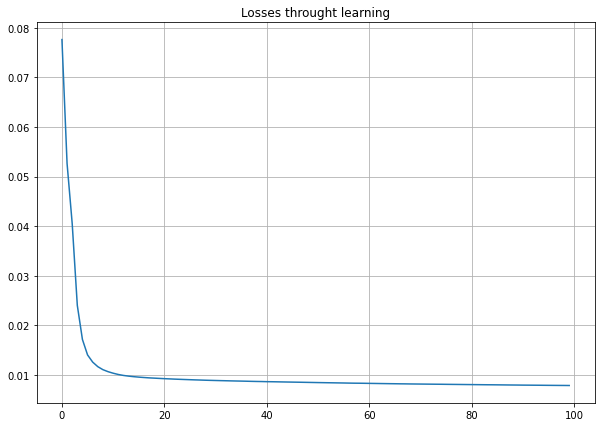

In [558]:
plt.grid()
plt.title("Losses throught learning")
plt.plot(losses_lstm)

In [560]:
y_preds = np.array(lstm.forward(X_test))

In [561]:
lstm_mse = mean_squared_error(y_preds, y_test)
rmse = np.sqrt(lstm_mse)
r2 = r2_score(y_preds, y_test)

In [562]:
print(f"MSE is {lstm_mse}")
print(f"RMSE is {rmse}")
print(f"R2 score is {r2}")

MSE is 0.005878209937434837
RMSE is 0.07666948504740877
R2 score is 0.8330909842187597


In [584]:
class GRU:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Init params
        self.Wxz = np.random.randn(hidden_size, input_size)
        self.Wxr = np.random.randn(hidden_size, input_size)
        self.Wxh = np.random.randn(hidden_size, input_size)
        self.Whz = np.random.randn(hidden_size, hidden_size)
        self.Whr = np.random.randn(hidden_size, hidden_size)
        self.Whh = np.random.randn(hidden_size, hidden_size)
        self.Why = np.random.randn(output_size, hidden_size)
        self.bz = np.zeros((hidden_size, 1))
        self.br = np.zeros((hidden_size, 1))
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        
        
        self.zero_grads()
        
    def zero_grads(self):

        self.dWxz = np.zeros(self.Wxz.shape)
        self.dWxr = np.zeros(self.Wxr.shape)
        self.dWxh = np.zeros(self.Wxh.shape)
        self.dWhz = np.zeros(self.Whz.shape)
        self.dWhr = np.zeros(self.Whr.shape)
        self.dWhh = np.zeros(self.Whh.shape)
        self.dWhy = np.zeros(self.Why.shape)
        self.dbz = np.zeros(self.bz.shape)
        self.dbr = np.zeros(self.br.shape)
        self.dbh = np.zeros(self.bh.shape)
        self.dby = np.zeros(self.by.shape)
        
    def update_weights(self, lr):
        self.Wxz = self.Wxz - lr*self.dWxz
        self.Wxr = self.Wxr - lr*self.dWxr

        self.Wxh = self.Wxh - lr*self.dWxh
        self.Whz = self.Whz - lr*self.dWhz

        self.Whr = self.Whr - lr*self.dWhr
        self.Whh = self.Whh - lr*self.dWhh

        self.Why = self.Why - lr*self.dWhy

        self.bz = self.bz - lr*self.dbz
        self.br = self.br - lr*self.dbr
        self.bh = self.bh - lr*self.dbh
        self.by = self.by - lr*self.dby
        
    def backward(self, y_pred, y_true):
        for i in range(y_pred.shape[0]):
            loc_grad = dmse(y_pred[i],y_true[i])
            loc_grad = loc_grad * relu2deriv(self.ys[i]) 
            loc_grad = loc_grad.reshape((loc_grad.shape[0], 1)) 
            self.dWhy += np.dot(loc_grad, self.h.T) 
            self.dby += loc_grad
            dht = np.dot(self.Why.T, loc_grad)
            for j in range(self.xs.shape[1]-1,-1,-1):
                dhat_h = dht * self.zs[i][j]
                drt = np.dot(np.dot(self.Whh, self.hs[i][j]).T ,dhat_h * (1 - self.h_hats[i][j] ** 2))
                # dr = np.dot(dh_hat * (1 - h_hat ** 2), hprev.T)
                dz = dht * (self.hs[i][j] - self.h_hats[i][j])
                
                self.dWhr += np.dot(drt * self.rs[i][j] * (1 - self.rs[i][j]), self.hs[i][j].T)
                self.dWxr += np.dot(drt * self.rs[i][j] * (1 - self.rs[i][j]), self.xs[i][j].reshape((self.xs[i][j].shape[0],1)).T)
                self.dbr += drt * self.rs[i][j] * (1 - self.rs[i][j])
                
                self.dWhz += np.dot(dz * self.zs[i][j] * (1 - self.zs[i][j]), self.hs[i][j].T)
                self.dWxz += np.dot(dz * self.zs[i][j] * (1 - self.zs[i][j]), self.xs[i][j].reshape((self.xs[i][j].shape[0],1)).T)
                self.dbz += dz * self.zs[i][j] * (1 - self.zs[i][j])
                
                self.dWhh += np.dot(dhat_h * (1 - self.h_hats[i][j] ** 2), (self.rs[i][j] * self.hs[i][j]).T)
                self.dWxh += np.dot(dhat_h * (1 - self.h_hats[i][j] ** 2), self.xs[i][j].reshape((self.xs[i][j].shape[0],1)).T)
                self.dbh += dhat_h * (1 - self.h_hats[i][j] ** 2)
                
    def train(self,  X_train, y_train, epochs = 100, lr = 0.0001,batch_size = 64):
        dataset = list(zip(X_train, y_train))
        losses = []
        for epoch in tqdm(range(epochs)):
            rng.shuffle(dataset)
            ep_loss = []
            for (X_batch, y_batch) in (get_batches(dataset, batch_size)):
                preds = self.forward(X_batch)
                ep_loss.append(mse(np.array(preds), y_batch))
                self.backward(np.array(preds), y_batch)
                self.update_weights(lr)
#                 print(f"Batch error is : {ep_loss[-1]}")
                self.zero_grads()
            
            losses.append(np.array(ep_loss).mean())
            print(f"Epoch №{epoch + 1}, epoch loss is {losses[-1]}")
        return losses
    
    
    def forward(self, X):
        predictions = []
        self.zs = []
        self.hs = []
        self.ys = []
        self.h_hats = []
        self.rs = []
        for x in X:
            zs_cur = []
            hs_cur = []
            h_hars_cur = []
            rs_cur = []
            self.h = np.zeros((self.hidden_size, 1))
            hs_cur.append(self.h)
            for x_i in x:
                x_i_r = x_i.reshape(self.input_size, 1)
                self.z = sigmoid(np.dot(self.Wxz, x_i_r) + np.dot(self.Whz,self.h) + self.bz)
                zs_cur.append(self.z)
                self.r = sigmoid(np.dot(self.Wxr, x_i_r) + np.dot(self.Whr, self.h) + self.br)
                rs_cur.append(self.r)
                self.h_hat = tanh(np.dot(self.Wxh, x_i_r) + np.dot(self.Whh, self.r * self.h) + self.bh)
                h_hars_cur.append(self.h_hat)
                self.h = (1 - self.z) * self.h + self.z * self.h_hat
                hs_cur.append(self.h)
                
            self.zs.append(zs_cur)
            self.hs.append(hs_cur)
            self.rs.append(rs_cur)
            self.h_hats.append(h_hars_cur)
            y = np.dot(self.Why, self.h) + self.by
            self.ys.append(y)
            y = relu(y)
            predictions.append(y.item())
        self.zs = np.array(self.zs)
        self.h_hats = np.array(self.h_hats)
        self.ys = np.array(self.ys)
        self.rs = np.array(self.rs)
        self.hs = np.array(self.hs)
        self.xs = X
        return predictions
        

In [653]:
gru = GRU(10,3,1)

In [654]:
gru_losses = gru.train(X_train, y_train, epochs = 100, lr = 0.0005,batch_size = 64)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\vepif\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
  1%|▊                                                                               | 1/100 [01:12<1:59:07, 72.19s/it]

Epoch №1, epoch loss is 0.07811640933295243


  2%|█▌                                                                              | 2/100 [02:00<1:46:07, 64.97s/it]

Epoch №2, epoch loss is 0.07809105621346185


  3%|██▍                                                                             | 3/100 [02:46<1:36:04, 59.43s/it]

Epoch №3, epoch loss is 0.07793275427699475


  4%|███▏                                                                            | 4/100 [03:34<1:29:34, 55.98s/it]

Epoch №4, epoch loss is 0.06590065357489329


  5%|████                                                                            | 5/100 [04:20<1:23:33, 52.77s/it]

Epoch №5, epoch loss is 0.041507455734159225


  6%|████▊                                                                           | 6/100 [05:11<1:22:15, 52.51s/it]

Epoch №6, epoch loss is 0.03680385158761326


  7%|█████▌                                                                          | 7/100 [06:03<1:20:47, 52.12s/it]

Epoch №7, epoch loss is 0.03323303743159014


  8%|██████▍                                                                         | 8/100 [06:43<1:14:17, 48.45s/it]

Epoch №8, epoch loss is 0.03025987719988944


  9%|███████▏                                                                        | 9/100 [07:25<1:10:33, 46.53s/it]

Epoch №9, epoch loss is 0.028062475612110484


 10%|███████▉                                                                       | 10/100 [08:08<1:08:12, 45.47s/it]

Epoch №10, epoch loss is 0.026061715177528928


 11%|████████▋                                                                      | 11/100 [08:51<1:06:19, 44.71s/it]

Epoch №11, epoch loss is 0.024757075670106005


 12%|█████████▍                                                                     | 12/100 [09:35<1:05:36, 44.73s/it]

Epoch №12, epoch loss is 0.02339721929716872


 13%|██████████▎                                                                    | 13/100 [10:15<1:02:34, 43.16s/it]

Epoch №13, epoch loss is 0.02245551216897893


 14%|███████████                                                                    | 14/100 [10:59<1:02:28, 43.59s/it]

Epoch №14, epoch loss is 0.021475810697405135


 15%|████████████▏                                                                    | 15/100 [11:36<58:48, 41.51s/it]

Epoch №15, epoch loss is 0.02066888708372953


 16%|████████████▉                                                                    | 16/100 [12:12<55:57, 39.97s/it]

Epoch №16, epoch loss is 0.01990913642957791


 17%|█████████████▊                                                                   | 17/100 [12:50<54:29, 39.39s/it]

Epoch №17, epoch loss is 0.019239605944488626


 18%|██████████████▌                                                                  | 18/100 [13:29<53:27, 39.11s/it]

Epoch №18, epoch loss is 0.01867648634181186


 19%|███████████████▍                                                                 | 19/100 [14:06<51:51, 38.42s/it]

Epoch №19, epoch loss is 0.018270733701267076


 20%|████████████████▏                                                                | 20/100 [14:46<51:53, 38.92s/it]

Epoch №20, epoch loss is 0.018063668792259156


 21%|█████████████████                                                                | 21/100 [15:20<49:28, 37.58s/it]

Epoch №21, epoch loss is 0.017707952280729838


 22%|█████████████████▊                                                               | 22/100 [15:55<47:54, 36.85s/it]

Epoch №22, epoch loss is 0.017339911477207866


 23%|██████████████████▋                                                              | 23/100 [16:31<46:40, 36.37s/it]

Epoch №23, epoch loss is 0.01699609788857843


 24%|███████████████████▍                                                             | 24/100 [17:06<45:42, 36.08s/it]

Epoch №24, epoch loss is 0.016691461638784072


 25%|████████████████████▎                                                            | 25/100 [17:41<44:44, 35.79s/it]

Epoch №25, epoch loss is 0.01641098157520464


 26%|█████████████████████                                                            | 26/100 [18:16<43:38, 35.39s/it]

Epoch №26, epoch loss is 0.01613367144571973


 27%|█████████████████████▊                                                           | 27/100 [19:02<46:59, 38.62s/it]

Epoch №27, epoch loss is 0.015917463590052056


 28%|██████████████████████▋                                                          | 28/100 [19:36<44:47, 37.32s/it]

Epoch №28, epoch loss is 0.01570535744432195


 29%|███████████████████████▍                                                         | 29/100 [20:22<47:15, 39.94s/it]

Epoch №29, epoch loss is 0.015506772152977022


 30%|████████████████████████▎                                                        | 30/100 [20:57<44:43, 38.33s/it]

Epoch №30, epoch loss is 0.015326757365882094


 31%|█████████████████████████                                                        | 31/100 [21:32<43:07, 37.50s/it]

Epoch №31, epoch loss is 0.01513132072536175


 32%|█████████████████████████▉                                                       | 32/100 [22:06<41:06, 36.28s/it]

Epoch №32, epoch loss is 0.014959776961746468


 33%|██████████████████████████▋                                                      | 33/100 [22:40<39:58, 35.80s/it]

Epoch №33, epoch loss is 0.014780956688834479


 34%|███████████████████████████▌                                                     | 34/100 [23:17<39:37, 36.02s/it]

Epoch №34, epoch loss is 0.014662646791519327


 35%|████████████████████████████▎                                                    | 35/100 [23:55<39:48, 36.74s/it]

Epoch №35, epoch loss is 0.014502275387041585


 36%|█████████████████████████████▏                                                   | 36/100 [24:29<38:11, 35.81s/it]

Epoch №36, epoch loss is 0.014353526247217413


 37%|█████████████████████████████▉                                                   | 37/100 [25:04<37:18, 35.53s/it]

Epoch №37, epoch loss is 0.014207947307633194


 38%|██████████████████████████████▊                                                  | 38/100 [25:41<37:11, 35.98s/it]

Epoch №38, epoch loss is 0.014109343186346187


 39%|███████████████████████████████▌                                                 | 39/100 [26:15<35:56, 35.35s/it]

Epoch №39, epoch loss is 0.013991818400686607


 40%|████████████████████████████████▍                                                | 40/100 [26:47<34:33, 34.55s/it]

Epoch №40, epoch loss is 0.013874803643243712


 41%|█████████████████████████████████▏                                               | 41/100 [27:20<33:26, 34.00s/it]

Epoch №41, epoch loss is 0.013768710951156869


 42%|██████████████████████████████████                                               | 42/100 [27:53<32:36, 33.74s/it]

Epoch №42, epoch loss is 0.01364443033394211


 43%|██████████████████████████████████▊                                              | 43/100 [28:26<31:52, 33.56s/it]

Epoch №43, epoch loss is 0.013532025261613009


 44%|███████████████████████████████████▋                                             | 44/100 [29:01<31:32, 33.79s/it]

Epoch №44, epoch loss is 0.013390001318398882


 45%|████████████████████████████████████▍                                            | 45/100 [29:37<31:37, 34.51s/it]

Epoch №45, epoch loss is 0.013277300264324103


 46%|█████████████████████████████████████▎                                           | 46/100 [30:15<31:54, 35.45s/it]

Epoch №46, epoch loss is 0.013186630408733458


 47%|██████████████████████████████████████                                           | 47/100 [30:49<31:04, 35.18s/it]

Epoch №47, epoch loss is 0.013120576528378954


 48%|██████████████████████████████████████▉                                          | 48/100 [31:25<30:33, 35.27s/it]

Epoch №48, epoch loss is 0.013108400196739227


 49%|███████████████████████████████████████▋                                         | 49/100 [31:59<29:50, 35.11s/it]

Epoch №49, epoch loss is 0.013028186554698893


 50%|████████████████████████████████████████▌                                        | 50/100 [32:32<28:43, 34.47s/it]

Epoch №50, epoch loss is 0.012957522952304899


 51%|█████████████████████████████████████████▎                                       | 51/100 [33:05<27:41, 33.91s/it]

Epoch №51, epoch loss is 0.012895152306072293


 52%|██████████████████████████████████████████                                       | 52/100 [33:38<27:01, 33.78s/it]

Epoch №52, epoch loss is 0.012773312424305091


 53%|██████████████████████████████████████████▉                                      | 53/100 [34:12<26:31, 33.86s/it]

Epoch №53, epoch loss is 0.012642344674313808


 54%|███████████████████████████████████████████▋                                     | 54/100 [34:48<26:16, 34.26s/it]

Epoch №54, epoch loss is 0.012603609673898094


 55%|████████████████████████████████████████████▌                                    | 55/100 [35:22<25:46, 34.37s/it]

Epoch №55, epoch loss is 0.012496683872049242


 56%|█████████████████████████████████████████████▎                                   | 56/100 [35:59<25:41, 35.04s/it]

Epoch №56, epoch loss is 0.01241647168690214


 57%|██████████████████████████████████████████████▏                                  | 57/100 [36:34<25:05, 35.00s/it]

Epoch №57, epoch loss is 0.01243366249047407


 58%|██████████████████████████████████████████████▉                                  | 58/100 [37:07<24:06, 34.44s/it]

Epoch №58, epoch loss is 0.012381221476316338


 59%|███████████████████████████████████████████████▊                                 | 59/100 [37:40<23:09, 33.89s/it]

Epoch №59, epoch loss is 0.012319216323874707


 60%|████████████████████████████████████████████████▌                                | 60/100 [38:14<22:36, 33.92s/it]

Epoch №60, epoch loss is 0.012246401436333407


 61%|█████████████████████████████████████████████████▍                               | 61/100 [38:49<22:26, 34.53s/it]

Epoch №61, epoch loss is 0.012168343434905773


 62%|██████████████████████████████████████████████████▏                              | 62/100 [39:26<22:17, 35.19s/it]

Epoch №62, epoch loss is 0.012089685303189388


 63%|███████████████████████████████████████████████████                              | 63/100 [40:02<21:52, 35.47s/it]

Epoch №63, epoch loss is 0.011995665999018395


 64%|███████████████████████████████████████████████████▊                             | 64/100 [40:41<21:54, 36.52s/it]

Epoch №64, epoch loss is 0.011907755128448314


 65%|████████████████████████████████████████████████████▋                            | 65/100 [41:22<21:57, 37.65s/it]

Epoch №65, epoch loss is 0.011794337994466426


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [42:03<22:00, 38.82s/it]

Epoch №66, epoch loss is 0.011761660384894583


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [42:40<21:03, 38.27s/it]

Epoch №67, epoch loss is 0.011716932050697746


 68%|███████████████████████████████████████████████████████                          | 68/100 [43:17<20:08, 37.76s/it]

Epoch №68, epoch loss is 0.01164020027423526


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [43:55<19:38, 38.01s/it]

Epoch №69, epoch loss is 0.011584991796000237


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [44:32<18:51, 37.72s/it]

Epoch №70, epoch loss is 0.01155378860979489


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [45:09<18:00, 37.27s/it]

Epoch №71, epoch loss is 0.011487178074169435


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [45:46<17:28, 37.45s/it]

Epoch №72, epoch loss is 0.011478450473945967


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [46:19<16:14, 36.08s/it]

Epoch №73, epoch loss is 0.011432788577489294


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [46:56<15:39, 36.14s/it]

Epoch №74, epoch loss is 0.011378741296108524


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [47:34<15:18, 36.75s/it]

Epoch №75, epoch loss is 0.01135763109742773


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [48:12<14:54, 37.28s/it]

Epoch №76, epoch loss is 0.011292888815065398


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [48:49<14:11, 37.03s/it]

Epoch №77, epoch loss is 0.011211318229042542


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [49:26<13:37, 37.17s/it]

Epoch №78, epoch loss is 0.011168572491185656


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [50:00<12:40, 36.23s/it]

Epoch №79, epoch loss is 0.01111846131658193


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [50:34<11:50, 35.53s/it]

Epoch №80, epoch loss is 0.011094117651725936


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [51:07<10:57, 34.58s/it]

Epoch №81, epoch loss is 0.011083809386512983


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [51:42<10:28, 34.89s/it]

Epoch №82, epoch loss is 0.011042281115486049


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [52:18<09:59, 35.25s/it]

Epoch №83, epoch loss is 0.011004745781851146


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [52:54<09:26, 35.38s/it]

Epoch №84, epoch loss is 0.01095638887894971


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [53:29<08:51, 35.41s/it]

Epoch №85, epoch loss is 0.010919592275146743


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [54:06<08:22, 35.90s/it]

Epoch №86, epoch loss is 0.010884020010841794


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [54:45<07:56, 36.68s/it]

Epoch №87, epoch loss is 0.010855643631693012


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [55:22<07:21, 36.79s/it]

Epoch №88, epoch loss is 0.010838486953221845


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [56:05<07:04, 38.63s/it]

Epoch №89, epoch loss is 0.0108176286975011


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [56:42<06:22, 38.27s/it]

Epoch №90, epoch loss is 0.01081435066020193


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [57:17<05:34, 37.19s/it]

Epoch №91, epoch loss is 0.0108016739751815


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [57:56<05:02, 37.81s/it]

Epoch №92, epoch loss is 0.0107704941325641


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [58:31<04:17, 36.79s/it]

Epoch №93, epoch loss is 0.010729956461634564


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [59:06<03:37, 36.26s/it]

Epoch №94, epoch loss is 0.010694644264220636


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [59:43<03:02, 36.47s/it]

Epoch №95, epoch loss is 0.010657203777051972


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96/100 [1:00:23<02:31, 37.77s/it]

Epoch №96, epoch loss is 0.010619184231493373


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97/100 [1:01:00<01:52, 37.40s/it]

Epoch №97, epoch loss is 0.010595582612968954


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98/100 [1:01:41<01:16, 38.42s/it]

Epoch №98, epoch loss is 0.010583270205969168


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99/100 [1:02:25<00:40, 40.19s/it]

Epoch №99, epoch loss is 0.010561289971562096


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:03:09<00:00, 37.90s/it]

Epoch №100, epoch loss is 0.010546188358414525


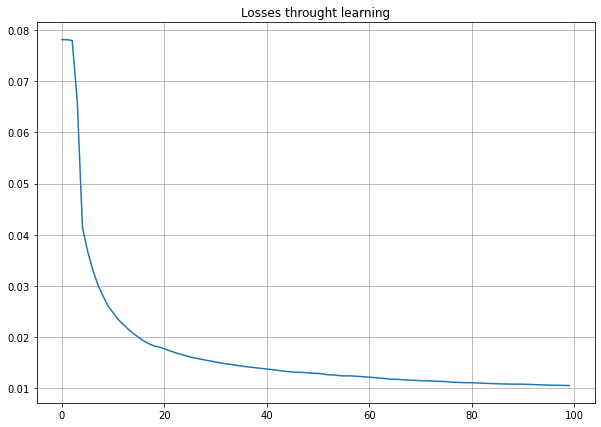

In [655]:
plt.grid()
plt.title("Losses throught learning")
plt.plot(gru_losses)

In [658]:
y_preds = np.array(gru.forward(X_test))

In [659]:
gru_mse = mean_squared_error(y_preds, y_test)
rmse = np.sqrt(gru_mse)
r2 = r2_score(y_preds, y_test)

In [662]:
print(f"MSE is {lstm_mse}")
print(f"RMSE is {rmse}")
print(f"R2 score is {r2}")

MSE is 0.005878209937434837
RMSE is 0.09038285513275762
R2 score is 0.7557299910032302
